imports

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, log_loss
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import phik
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

Importazione dataset

In [17]:
df = pd.read_csv("data/NPHA-doctor-visits.csv")


ANALISI ESPLORATIVA DEI DATI

   Number of Doctors Visited  Age  Phyiscal Health  Mental Health  \
0                          3    2                4              3   
1                          2    2                4              2   
2                          3    2                3              2   
3                          1    2                3              2   
4                          3    2                3              3   

   Dental Health  Employment  Stress Keeps Patient from Sleeping  \
0              3           3                                   0   
1              3           3                                   1   
2              3           3                                   0   
3              3           3                                   0   
4              3           3                                   1   

   Medication Keeps Patient from Sleeping  Pain Keeps Patient from Sleeping  \
0                                       0                                 0   
1                 

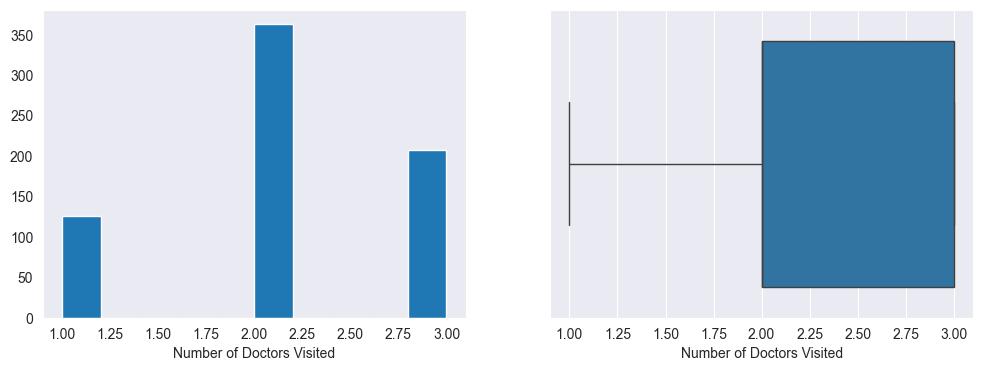

Age


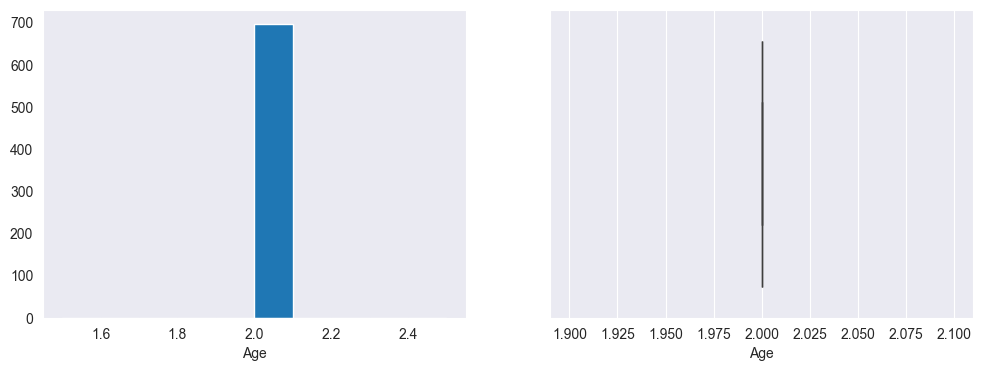

Phyiscal Health


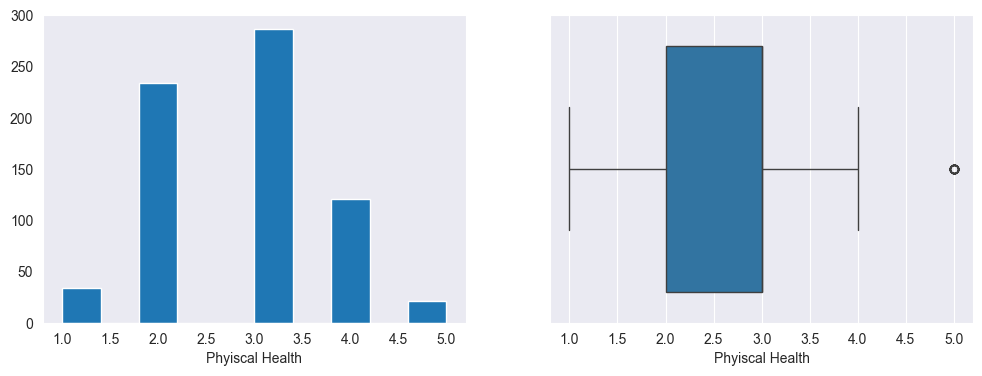

Mental Health


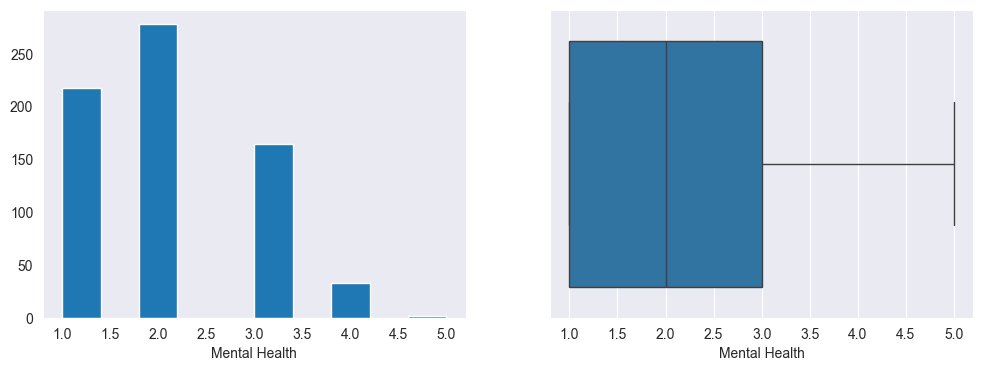

Dental Health


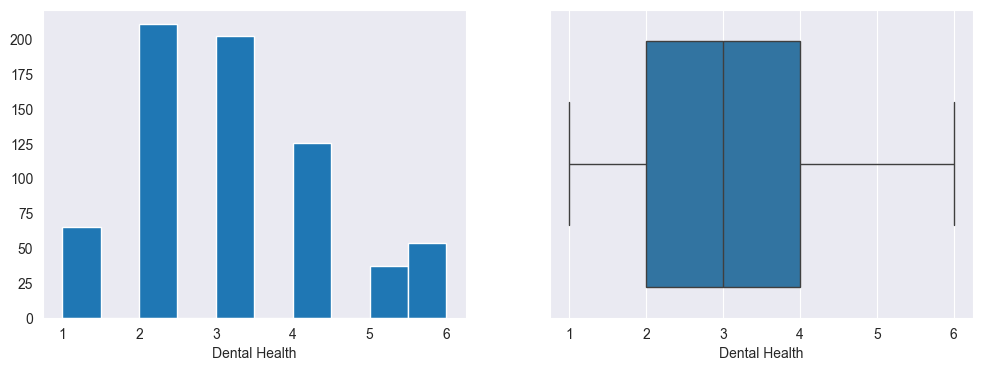

Employment


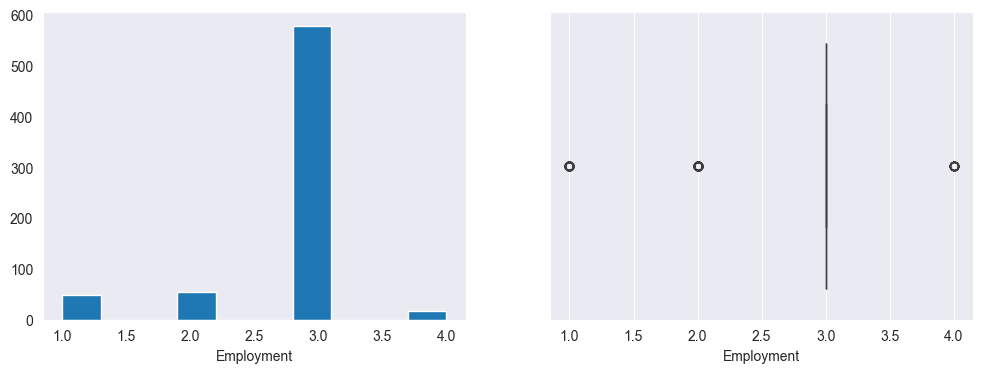

Stress Keeps Patient from Sleeping


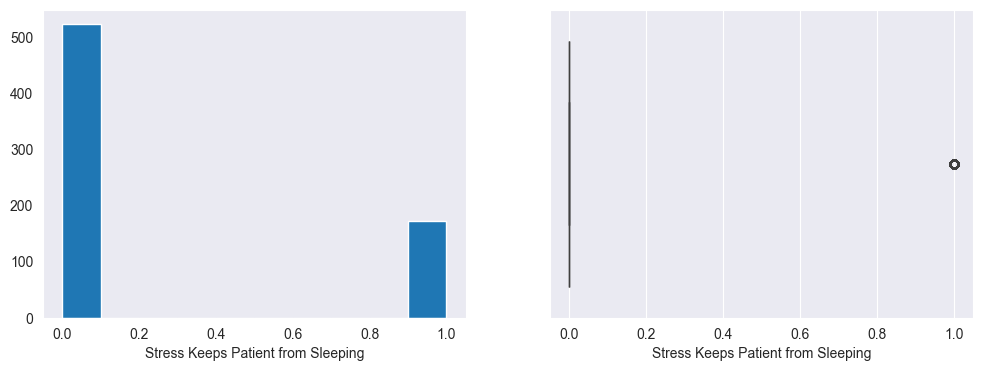

Medication Keeps Patient from Sleeping


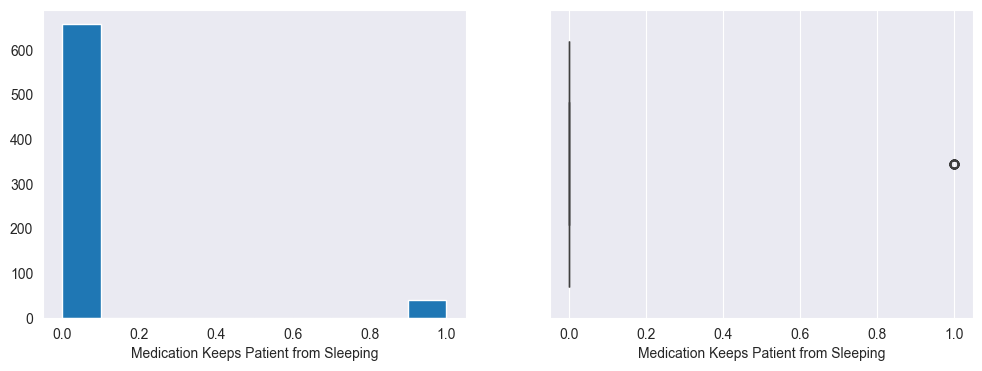

Pain Keeps Patient from Sleeping


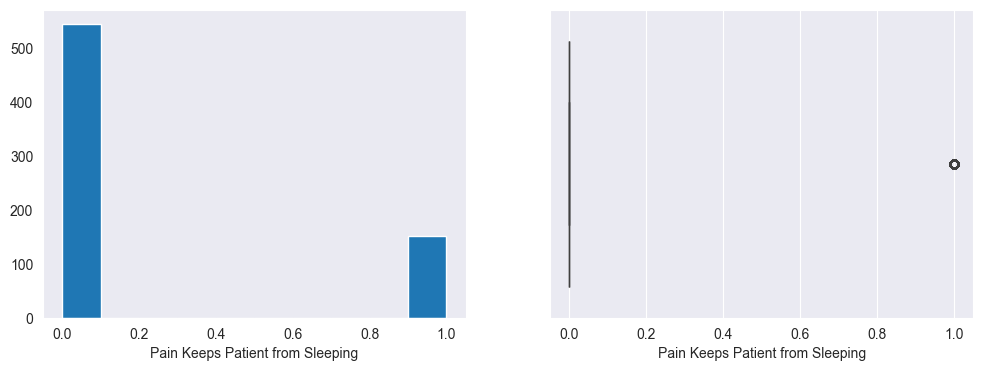

Bathroom Needs Keeps Patient from Sleeping


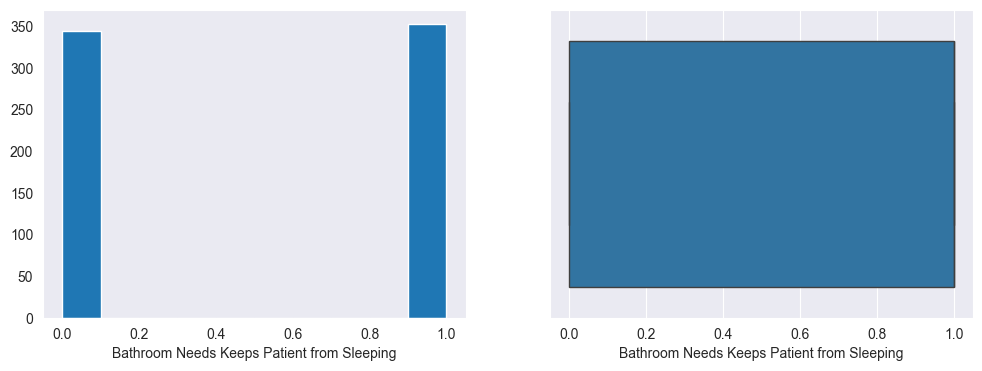

Uknown Keeps Patient from Sleeping


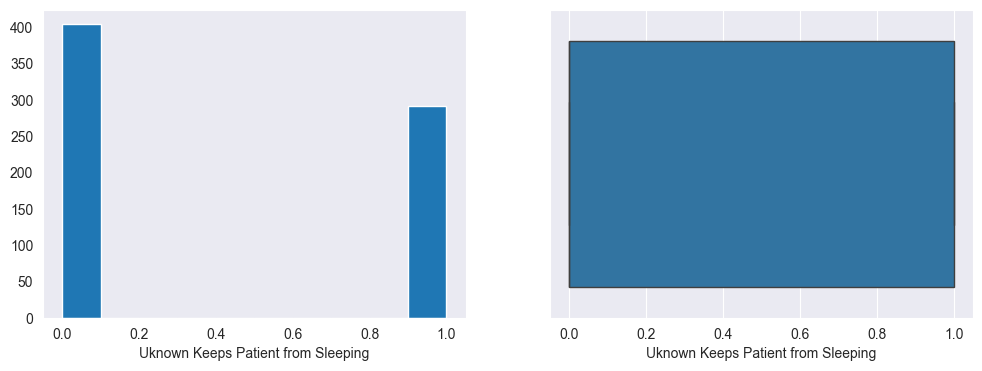

Trouble Sleeping


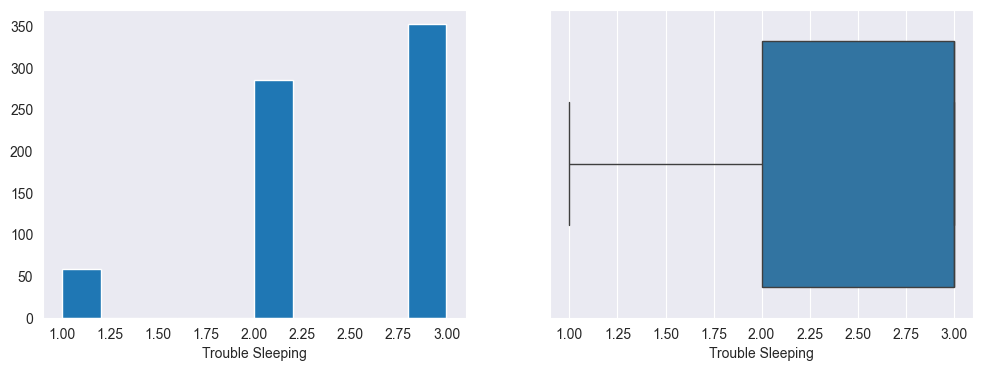

Prescription Sleep Medication


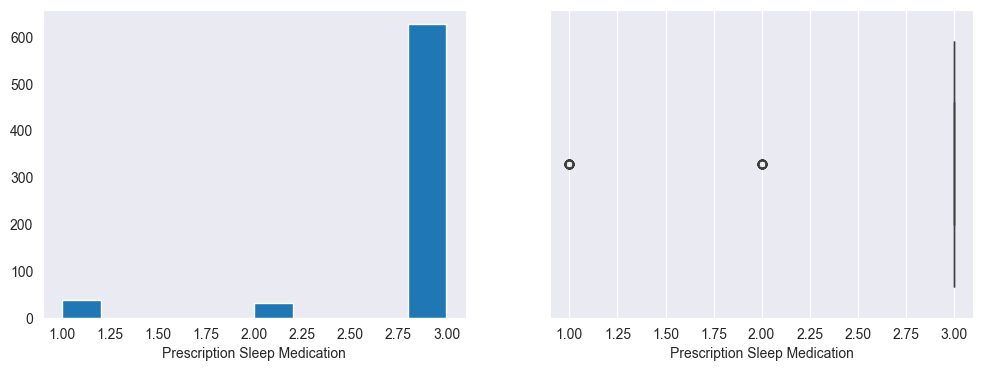

Race


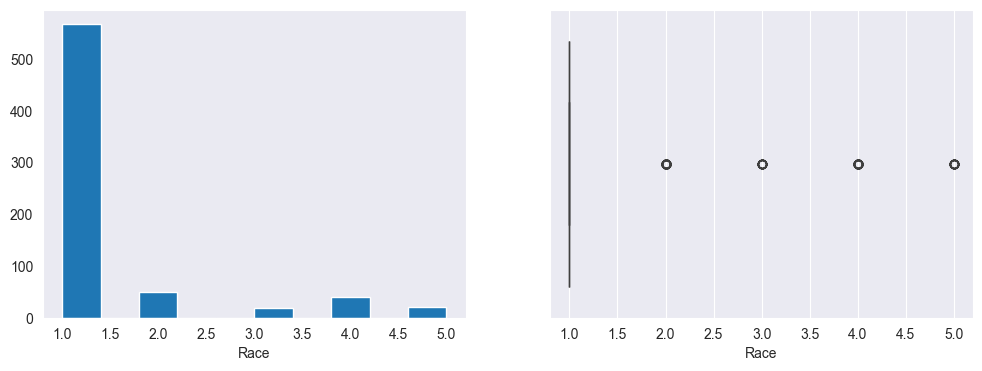

Gender


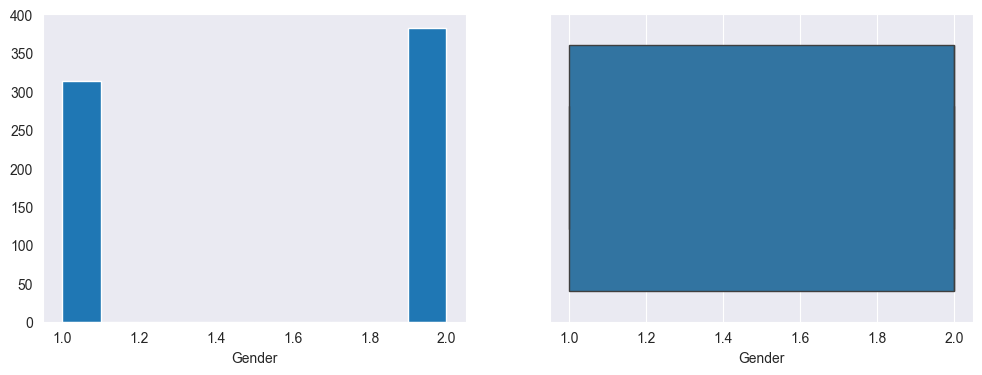

In [18]:
print(df.head())
print(df.dtypes)
print(df.describe())

#Pulizia dei dati (nel paper di riferimento, -1 e -2 sono descritti rispettivamente come "Refused" e
#"Not asked")
df_cleaned = df.replace([-1, -2], np.nan).dropna()

#vediamo la distribuzione dei dati di ogni colonna (feature)
colonne = df_cleaned.columns.tolist()
for colonna in colonne:
    print(colonna)
    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    df_cleaned[colonna].hist(grid=False)
    plt.xlabel(colonna)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_cleaned[colonna])
    plt.show()

Riflessione su Trouble Sleeping
Trouble Sleeping è indicata come variabile binaria (0 e 1), ma nel dataset assume valori discreti tra 1 e 3,
prima di fare modifiche (eliminarla o trasformarla in binaria), analizzo la correlazione tra con il target:
non c'è alcuna differenza nei valori di Trouble Sleeping tra chi ha 1, 2 o 3 visite dal medico
Lascio la variabile invariata, ????

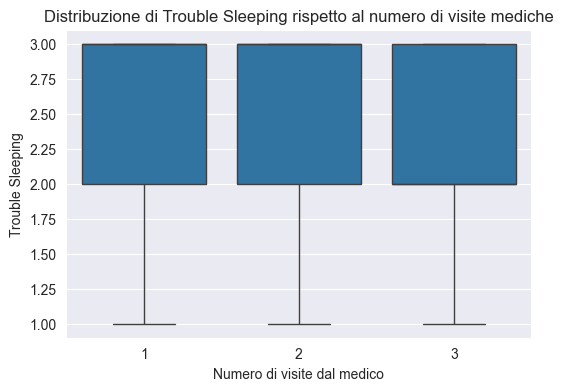

In [19]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_cleaned["Number of Doctors Visited"], y=df_cleaned["Trouble Sleeping"])
plt.title("Distribuzione di Trouble Sleeping rispetto al numero di visite mediche")
plt.xlabel("Numero di visite dal medico")
plt.ylabel("Trouble Sleeping")
plt.show()

Matrice di correlazione lineare

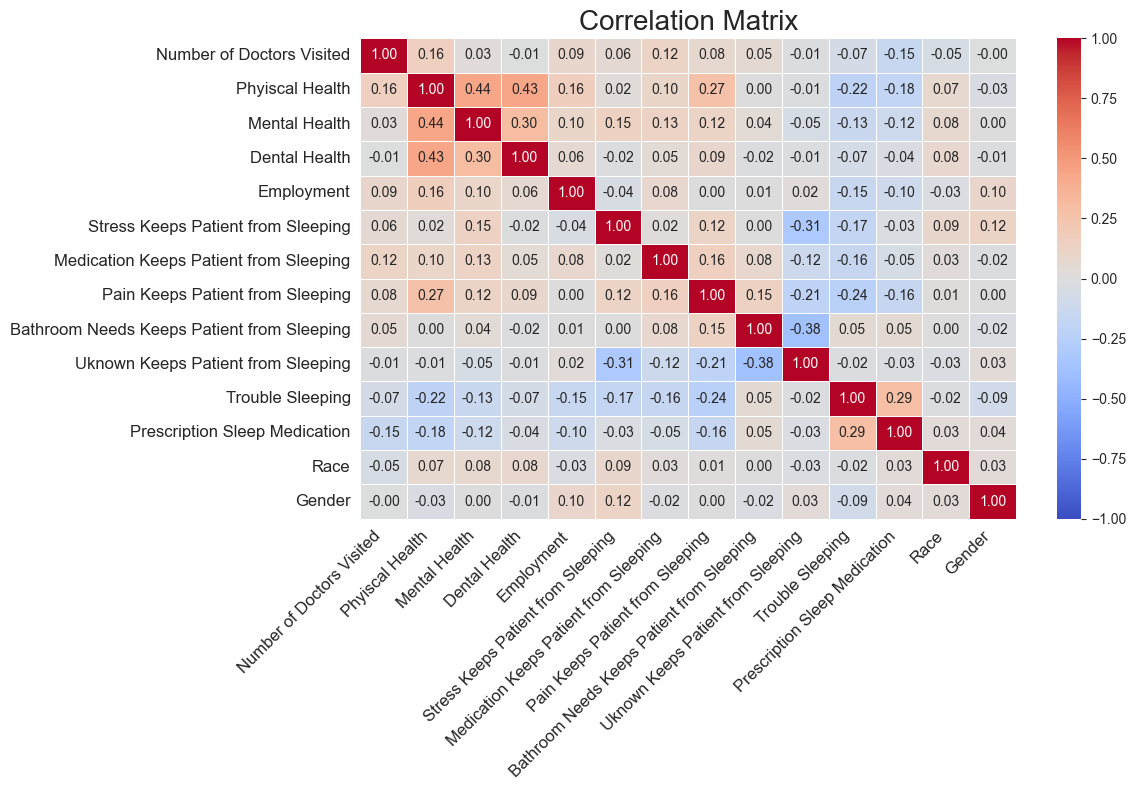

In [20]:
df_cleaned =  df_cleaned.drop(columns=['Age'])
correlation_matrix = df_cleaned.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix")
plt.title("Correlation Matrix", fontsize=20)  # Aumenta la dimensione del titolo
plt.xticks(rotation=45, ha="right", fontsize=12)  # Ruota e ridimensiona le etichette
plt.yticks(fontsize=12)  # Dimensione delle etichette sull'asse Y
plt.tight_layout()  # Regola automaticamente gli spazi
plt.show()

Matrice di correlazione Phi-k

interval columns not set, guessing: ['Number of Doctors Visited', 'Phyiscal Health', 'Mental Health', 'Dental Health', 'Employment', 'Stress Keeps Patient from Sleeping', 'Medication Keeps Patient from Sleeping', 'Pain Keeps Patient from Sleeping', 'Bathroom Needs Keeps Patient from Sleeping', 'Uknown Keeps Patient from Sleeping', 'Trouble Sleeping', 'Prescription Sleep Medication', 'Race', 'Gender']


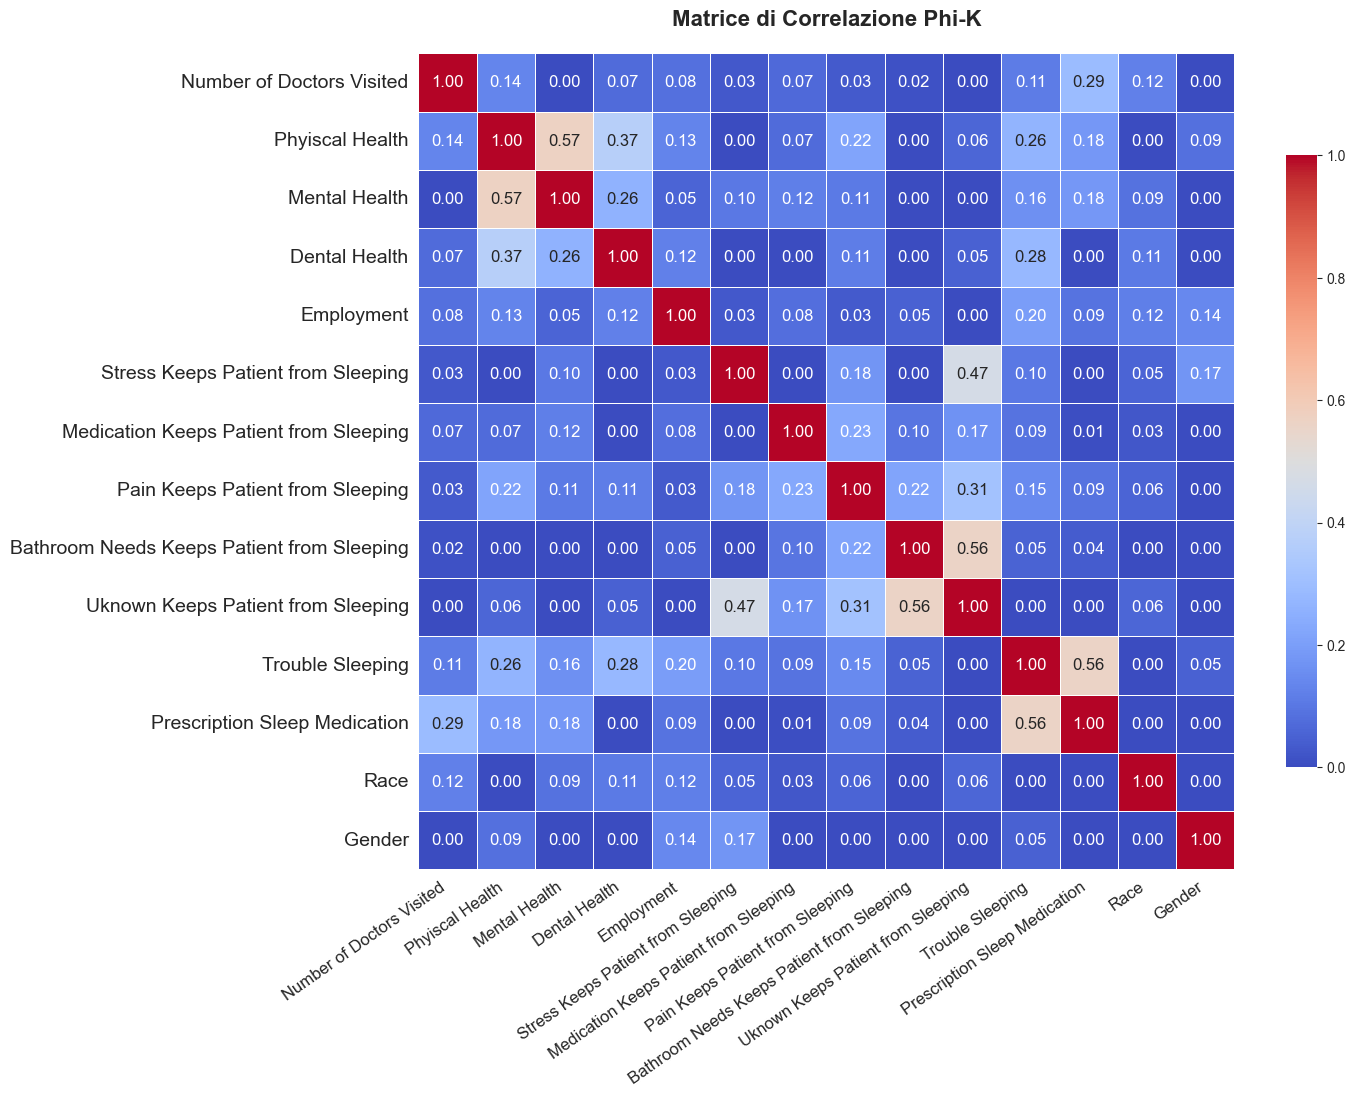

In [21]:
phik_corr =df_cleaned.phik_matrix()

plt.figure(figsize=(16, 12))
# Heatmap con parametri migliorati per la leggibilità
sns.heatmap(
    phik_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.7,  # Separazione tra le celle
    square=True,      # Mantiene la forma quadrata
    cbar_kws={"shrink": 0.75},
    annot_kws={"size": 12}# Riduce la dimensione della barra dei colori
)

# Miglioramento della leggibilità degli assi
plt.xticks(rotation=35, ha="right", fontsize=12)  # Ruota le etichette dell'asse X
plt.yticks(fontsize=14)  # Aumenta la dimensione del font delle etichette Y
plt.title("Matrice di Correlazione Phi-K", fontsize=16, fontweight="bold", pad=20)
plt.subplots_adjust(left=0.35, right=1.0, bottom=0.2) # Regolazione dei margini
plt.show()

Preparazione del dataset per l'addestramento

Distribuzione delle classi target nel dataset originale:
Number of Doctors Visited
2    363
3    207
1    126
Name: count, dtype: int64


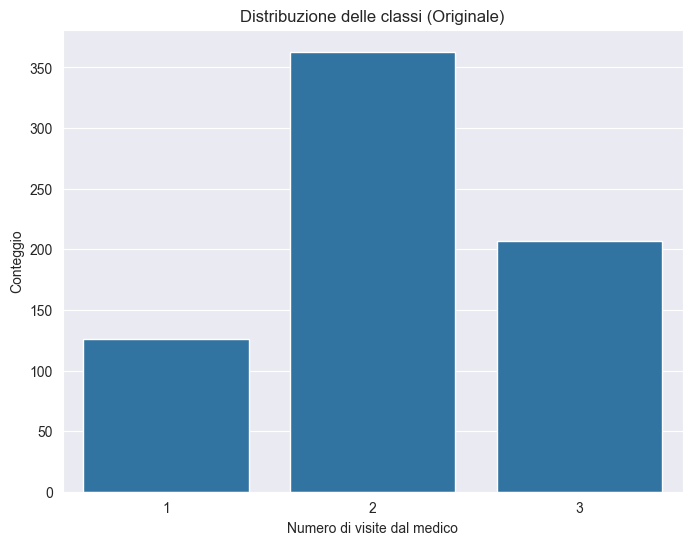

In [22]:
#definiamo la variabile target e l'insieme delle features
X = df_cleaned.drop(columns=['Number of Doctors Visited'])
y = df_cleaned['Number of Doctors Visited']

# Analisi della distribuzione delle classi della variabile target
print("Distribuzione delle classi target nel dataset originale:")
print(y.value_counts())

# Grafico della distribuzione della variabile target
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title("Distribuzione delle classi (Originale)")
plt.xlabel("Numero di visite dal medico")
plt.ylabel("Conteggio")
plt.show()

PREPARAZIONE DEI DATI: Train/Test Split

In [32]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

5. Logistic Regression: Primo Tentativo

Fitting 5 folds for each of 45 candidates, totalling 225 fits

===== Logistic Regression Results =====
Accuracy: 0.3810, F1-Score: 0.3989


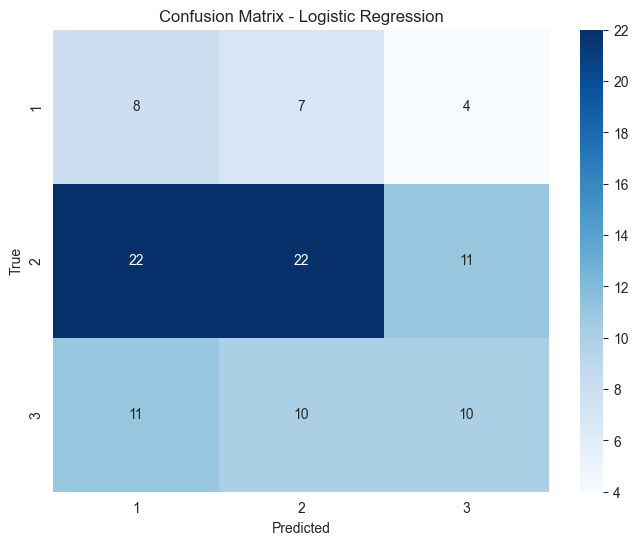

In [33]:
#faccio One-Hot Encoding delle features nominali
categorical_features = ["Race", "Gender"]
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features),
        ("num", StandardScaler(), list(set(X.columns) - set(categorical_features)))
    ]
)
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

smote_nc = SMOTENC(categorical_features=[X_train_encoded.shape[1] - len(categorical_features)], random_state=42)
X_train_balanced, y_train_balanced = smote_nc.fit_resample(X_train_encoded, y_train)

param_grid_logreg = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'max_iter': [1000, 2000, 3000]
}

logreg = LogisticRegression(class_weight="balanced", random_state=42)
grid_search_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search_logreg.fit(X_train_balanced, y_train_balanced)

best_logreg = grid_search_logreg.best_estimator_
y_pred_logreg = best_logreg.predict(X_test_encoded)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg, average='weighted')

print("\n===== Logistic Regression Results =====")
print(f"Accuracy: {accuracy_logreg:.4f}, F1-Score: {f1_logreg:.4f}")

conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logreg, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

Modelli Avanzati: Random Forest e CatBoost

In [34]:


# ===================== 2. Parametri per GridSearchCV =====================
param_grid_cat = {"iterations": [50, 100, 200], "learning_rate": [0.05, 0.1, 0.2], "depth": [4, 6, 8]}
param_grid_rf = {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20], "min_samples_split": [2, 5, 10]}

models = {
    "CatBoost": {"classifier": CatBoostClassifier(random_seed=42, verbose=False), "param_grid": param_grid_cat},
    "RandomForest": {"classifier": RandomForestClassifier(random_state=42), "param_grid": param_grid_rf}
}

best_params = {}
results = []

# ===================== 3. GridSearchCV e valutazione su test set =====================
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for model_name, model_dict in models.items():
    print(f"\n🔍 Ottimizzazione di {model_name}...")
    model = model_dict["classifier"]
    param_grid = model_dict["param_grid"]

    # GridSearchCV per trovare i migliori iperparametri
    grid_search = GridSearchCV(model, param_grid, cv=skf, scoring="accuracy", n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_params[model_name] = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Valutazione su set di validazione
    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    print(f"Val Accuracy per {model_name}: {val_accuracy:.4f}")
    print(f"Val F1-Score per {model_name}: {val_f1:.4f}")

    # Valutazione finale su test set
    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    results.append([model_name, test_accuracy, test_f1])

    # Cross-validation finale su tutto il dataset
    cross_val_scores = cross_val_score(best_model, X, y, cv=5, scoring="accuracy")
    print(f"Cross-Validation Accuracy per {model_name}: {cross_val_scores.mean():.4f} (+/- {cross_val_scores.std():.4f})")



🔍 Ottimizzazione di CatBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Val Accuracy per CatBoost: 0.5481
Val F1-Score per CatBoost: 0.4260
Cross-Validation Accuracy per CatBoost: 0.5216 (+/- 0.0107)

🔍 Ottimizzazione di RandomForest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Val Accuracy per RandomForest: 0.5192
Val F1-Score per RandomForest: 0.4256
Cross-Validation Accuracy per RandomForest: 0.5101 (+/- 0.0225)


Creazione DataFrame con i risultati

In [35]:
df_results = pd.DataFrame(results, columns=["Modello", "Accuracy", "F1-Score"])
print("\n===== RISULTATI OTTIMIZZATI =====")
print(df_results)



===== RISULTATI OTTIMIZZATI =====
        Modello  Accuracy  F1-Score
0      CatBoost  0.552381  0.419101
1  RandomForest  0.580952  0.493835


8. Matrice di Confusione

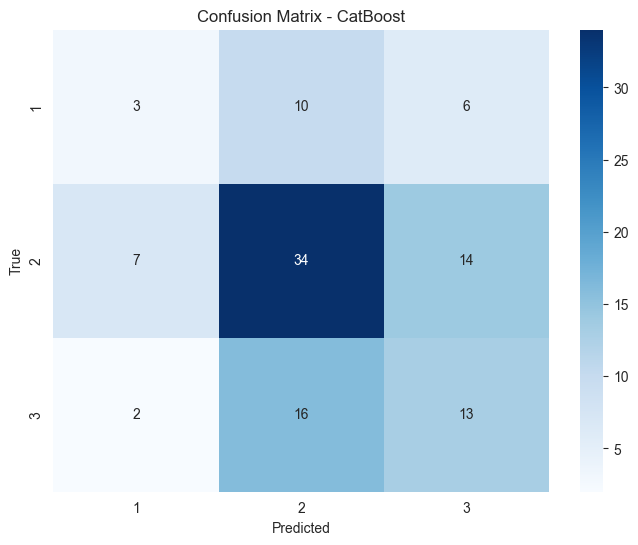

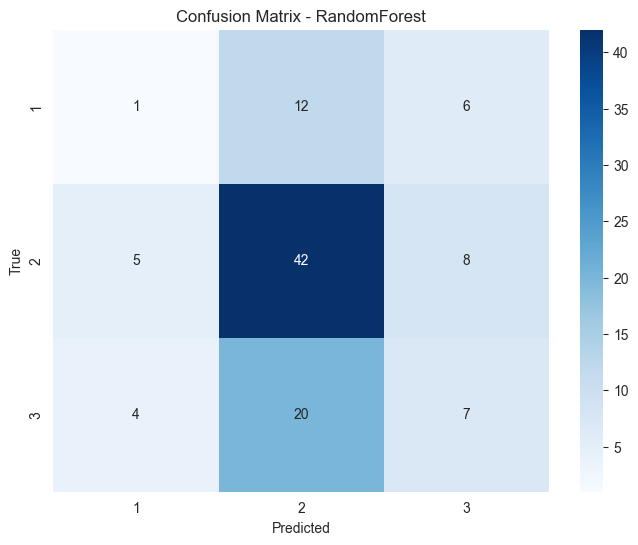

In [27]:
for model_name in models.keys():
    best_model = models[model_name]["classifier"]
    best_model.fit(X_train, y_train)
    y_pred_test = best_model.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


Stessa cosa usando SMOTE

In [37]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\n===== Dopo SMOTE =====")
print("Training set (SMOTE):", y_train_smote.value_counts())

# ===================== 3. Parametri per GridSearchCV =====================
param_grid_cat = {"iterations": [50, 100, 200], "learning_rate": [0.05, 0.1, 0.2], "depth": [4, 6, 8]}
param_grid_rf = {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20], "min_samples_split": [2, 5, 10]}

models = {
    "CatBoost": {"classifier": CatBoostClassifier(random_seed=42, verbose=False), "param_grid": param_grid_cat},
    "RandomForest": {"classifier": RandomForestClassifier(random_state=42), "param_grid": param_grid_rf}
}

best_params = {}
results = []

# ===================== 4. GridSearchCV e valutazione =====================
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for model_name, model_dict in models.items():
    print(f"\n🔍 Ottimizzazione di {model_name}...")
    model = model_dict["classifier"]
    param_grid = model_dict["param_grid"]

    grid_search = GridSearchCV(model, param_grid, cv=skf, scoring="accuracy", n_jobs=-1, verbose=1)
    grid_search.fit(X_train_smote, y_train_smote)

    best_params[model_name] = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Valutazione su set di validazione
    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    print(f"Val Accuracy per {model_name}: {val_accuracy:.4f}")
    print(f"Val F1-Score per {model_name}: {val_f1:.4f}")

    # Valutazione finale su test set
    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    results.append([model_name, test_accuracy, test_f1])

# ===================== 5. Risultati finali =====================
df_results = pd.DataFrame(results, columns=["Modello", "Test Accuracy", "Test F1-Score"])
print("\n===== RISULTATI FINALI =====")
print(df_results)


===== Dopo SMOTE =====
Training set (SMOTE): Number of Doctors Visited
2    254
3    254
1    254
Name: count, dtype: int64

🔍 Ottimizzazione di CatBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Val Accuracy per CatBoost: 0.3846
Val F1-Score per CatBoost: 0.3831

🔍 Ottimizzazione di RandomForest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Val Accuracy per RandomForest: 0.3558
Val F1-Score per RandomForest: 0.3596

===== RISULTATI FINALI =====
        Modello  Test Accuracy  Test F1-Score
0      CatBoost       0.428571       0.426325
1  RandomForest       0.380952       0.373168
